<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Interpreting a weather classification model with LIME
This notebook demonstrates the use of DIANNA with the LIME timeseries method on the weather dataset.

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

*NOTE*: This tutorial is still work-in-progress, the final results need to be improved by tweaking the LIME parameters

#### Colab Setup

In [ ]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # install dianna
  !python3 -m pip install dianna[notebooks]
  
  # download data used in this demo
  import os 
  base_url = 'https://raw.githubusercontent.com/dianna-ai/dianna/main/tutorials/'
  paths_to_download = ['models/season_prediction_model_temp_max_binary.onnx']
  for path in paths_to_download:
      !wget {base_url + path} -P {os.path.dirname(path)}

### Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from dianna import visualization
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import onnx
import onnxruntime as ort
import dianna

np.random.seed(0)

#### 1 - Create a mini dataset with extremes for verification
To demonstrate the skill of RISE for timeseries model explanation, we "make up" a weather dataset (timeseries) with extrem hot days and cold days.

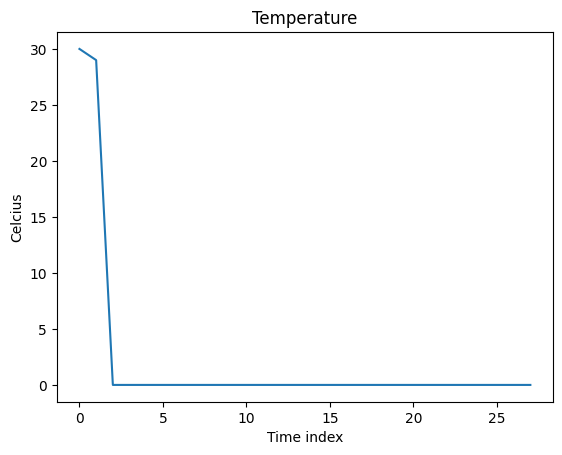

In [2]:
# make up a weather dataset with extrems
cold_with_2_hot_days = np.expand_dims(np.array([30, 29] + list(np.zeros(26))) , axis=1)
data_extreme = cold_with_2_hot_days
fig = plt.figure()
plt.plot(data_extreme)
plt.xlabel("Time index")
plt.ylabel("Celcius")
plt.title("Temperature")
plt.show()

#### 2 - Define an "expert" model to verify RISE for timeseries
We can define an 'expert' model to test RISE. This expert model decides it's summer if the mean temp is above the threshold, and winter in other cases.

In [3]:
# We define a threshold for the model to make decisions
# The label is ["summer", "winter"]
threshold = 14

def run_expert_model(data):
    is_summer = np.mean(np.mean(data, axis=1), axis=1) > threshold
    number_of_classes = 2
    number_of_instances = data.shape[0]
    result = np.zeros((number_of_instances ,number_of_classes))
    result[is_summer] = [1.0, 0.0]
    result[~is_summer] = [0.0, 1.0]
    return result

#### 3 - Compute and visualize the relevance scores
In this section we compute the relevance scores for each segment of timeseries using LIME and visualize them on the original timeseries.

In [6]:
# we use the threshold to mask the data
def input_train_mean(_data):
    return threshold

In [9]:
exp = dianna.explain_timeseries(run_expert_model, timeseries_data=data_extreme, method='lime',
                                labels=[0, 1], class_names=["summer", "winter"], num_features=len(data_extreme),
                                num_samples=10000, num_slices=len(data_extreme), distance_method='cosine')

Explaining: 100%|██████████| 10000/10000 [00:00<00:00, 33276.74it/s]


Now we can visualize the relevance scores on top of the displayed timeseries using the visualization tool in dianna. <br>
TODO: further test LIME with our fake data and try to pass it.

/tmp/ipykernel_3163/3463153371.py:4: RuntimeWarning: invalid value encountered in divide
  zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))


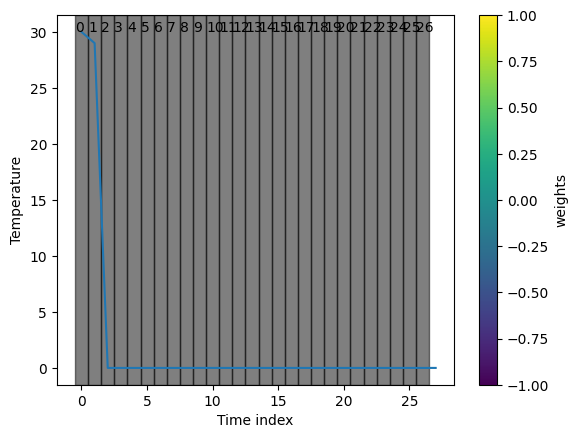

<AxesSubplot: xlabel='Time index', ylabel='Temperature'>

In [10]:
# Normalize the explanation scores for the purpose of visualization
def normalize(data):
    """Squash all values into [-1,1] range."""
    zero_to_one = (data - np.min(data)) / (np.max(data) - np.min(data))
    return 2*zero_to_one -1

local_exp = exp.local_exp[1]
local_exp_list = [i[1] for i in local_exp]

heatmap_channel = normalize(local_exp_list)
segments = []
for i in range(len(heatmap_channel) - 1):
    segments.append({
        'index': i,
        'start': i - 0.5,
        'stop': i + 0.5,
        'weight': heatmap_channel[i]})
visualization.plot_timeseries(range(len(heatmap_channel)), data_extreme,
                              segments, xlabel="Time index", ylabel="Temperature",
                              show_plot=True)

Here we plot the explanation for the classification of summer. The results are consistent with our expectation as it marks all hot days in the timeseries. <br>

Now let's try out RISE with a weather prediction dataset from real life. <br>
Here is the doi to this dataset: <br>
10.5281/zenodo.4770936

#### 4 - Loading the weather prediction dataset
Downloading the weather prediction dataset from zenodo.

In [11]:
# Load weather dataset
fname = "weather_prediction_dataset.csv"
if os.path.isfile(fname):
    data = pd.read_csv(fname)
else:
    data = pd.read_csv(f"https://zenodo.org/record/5071376/files/{fname}?download=1")
data.describe()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
count,3.654000e+03,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,...,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000,3654.000000
mean,2.004568e+07,6.520799,5.418446,0.745107,1.017876,1.330380,0.234849,4.661193,11.022797,6.989135,...,5.104215,11.470635,3.677258,0.781872,1.016639,1.369787,0.186100,12.205802,7.860536,16.551779
std,2.874287e+04,3.450083,2.325497,0.107788,0.007962,0.935348,0.536267,4.330112,7.414754,6.653356,...,7.250744,8.950217,1.519866,0.115572,0.018885,0.926472,0.422151,6.467155,5.692256,7.714924
min,2.000010e+07,1.000000,0.000000,0.380000,0.985600,0.050000,0.000000,0.000000,-9.300000,-16.000000,...,-19.700000,-14.500000,0.700000,0.330000,0.000300,0.050000,0.000000,-6.200000,-13.000000,-3.100000
25%,2.002070e+07,4.000000,4.000000,0.670000,1.013300,0.530000,0.000000,0.500000,5.300000,2.000000,...,0.000000,4.100000,2.600000,0.700000,1.012100,0.550000,0.000000,7.600000,3.700000,10.800000
50%,2.004567e+07,7.000000,6.000000,0.760000,1.017700,1.110000,0.000000,3.600000,11.400000,7.300000,...,5.000000,11.000000,3.400000,0.800000,1.017300,1.235000,0.000000,12.300000,8.300000,16.600000
75%,2.007070e+07,10.000000,7.000000,0.830000,1.022700,2.060000,0.210000,8.000000,16.900000,12.400000,...,11.200000,19.000000,4.600000,0.870000,1.022200,2.090000,0.160000,17.200000,12.300000,22.400000
max,2.010010e+07,12.000000,8.000000,0.980000,1.040800,3.550000,7.570000,15.300000,29.000000,20.800000,...,21.200000,32.900000,10.800000,1.000000,1.041400,3.560000,6.200000,31.200000,22.600000,39.800000


Given how the classification model is trained, we prepare the testing data for prediction. <br>
To make it simpler, we only choose one location and make it a binary classification task, to determine whether it is summer or winter.

In [12]:
# select only data from De Bilt
columns = [col for col in data.columns if col.startswith('DE_BILT') and col.endswith('temp_max')]#[:9]
data_debilt = data[columns]
data_debilt.describe()

,DE_BILT_temp_max
count,3654.000000
mean,14.798604
std,7.210740
min,-4.700000
25%,9.200000
50%,14.900000
75%,20.200000
max,35.700000


In [13]:
# find where the month changes
idx = np.where(np.diff(data['MONTH']) != 0)[0]
# idx contains the index of the last day of each month, except for the last month.
# of the last month only a single day is recorded, so we discard it.

nmonth = len(idx)
# add start of first month
idx = np.insert(idx, 0, 0)
ncol = len(columns)
# create single object containing each timeseries
# for simplicity we truncate each timeseries to the same length, i.e. 28 days
nday = 28
data_ts = np.zeros((nmonth, nday, ncol))
for m in range(nmonth):
    data_ts[m] = data_debilt[idx[m]:idx[m+1]][:28]
    
print(data_ts.shape)

(120, 28, 1)


We label the data based on the seasons. <br>
To simplify the problem, we make it a binary classification task and only select summer and winter. <br>

In [14]:
# the labels are based on the month of each timeseries, in range 1 to 12
months = (np.arange(nmonth) + data['MONTH'][0] - 1) % 12 + 1

# one class per meteorological season
labels = np.zeros_like(months, dtype=int)
spring = (3 <= months) & (months <= 5)   # mar - may
summer = (6 <= months) & (months <= 8)   # jun - aug
autumn = (9 <= months) & (months <= 11)  # sep - nov
winter = (months <= 2) | (months == 12)  # dec - feb

labels[spring] = 0
labels[summer] = 1
labels[autumn] = 2
labels[winter] = 3

target = pd.get_dummies(labels)

classes = ['spring', 'summer', 'autumn', 'winter']
nclass = len(classes)

target.describe()

,0,1,2,3
count,120.000000,120.000000,120.000000,120.000000
mean,0.250000,0.250000,0.250000,0.250000
std,0.434828,0.434828,0.434828,0.434828
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.250000,0.250000,0.250000,0.250000
max,1.000000,1.000000,1.000000,1.000000


In [15]:
classes = ['summer', 'winter']
nclass = 2
labels[summer] = 0
labels[winter] = 1
target = pd.get_dummies(labels[summer + winter])
data_ts = data_ts[summer + winter]

Train/test split

In [16]:
data_trainval, data_test, target_trainval, target_test = train_test_split(data_ts, target, stratify=target, random_state=0, test_size=.12)
data_train, data_val, target_train, target_val = train_test_split(data_trainval, target_trainval, stratify=target_trainval, random_state=0, test_size=.12)
print(data_train.shape, data_val.shape, data_test.shape)

(45, 28, 1) (7, 28, 1) (8, 28, 1)


Load ONNX model and create a ONNX model runner.

In [17]:
# onnx model available on surf drive
# path to ONNX model
onnx_file = 'models/season_prediction_model_temp_max_binary.onnx'

# verify the ONNX model is valid
onnx_model = onnx.load(onnx_file)
onnx.checker.check_model(onnx_model)

def run_model(data):
    # model must receive input in the order of [batch, timeseries, channels]
    # data = data.transpose([0,2,1])
    # get ONNX predictions
    sess = ort.InferenceSession(onnx_file)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    
    return pred_onnx

In [22]:
idx = 6 # explained instance
data_instance = data_test[idx][np.newaxis, ...]
# precheck ONNX predictions
pred_onnx = run_expert_model(data_instance)
pred_class = classes[np.argmax(pred_onnx)]
print("The actual class is:", classes[np.argmax(target_test.iloc[idx])])

The actual class is: winter


#### 3. Applying LIME with DIANNA

In [41]:
num_features = 5
num_slices = len(data_instance[0])

In [42]:
#Run explainer from dianna class
from dianna.methods import lime_timeseries
explainer = lime_timeseries.LIMETimeseries()
exp = explainer.explain(run_model, data_instance[0], labels=[0,1],
                        class_names=classes, num_features=num_features, num_samples=1000,
                        num_slices=num_slices, distance_method='cosine')

Explaining: 100%|██████████| 1000/1000 [00:04<00:00, 210.42it/s]


#### 4. Plot results 

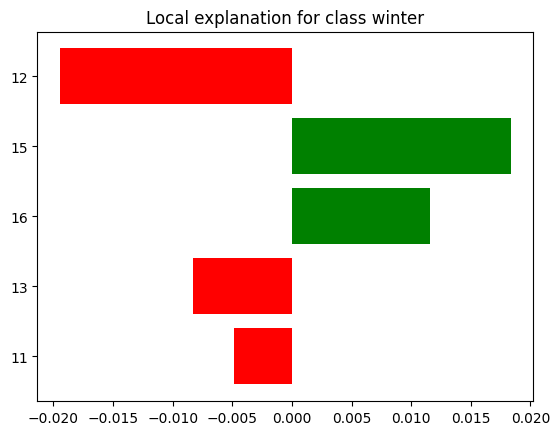

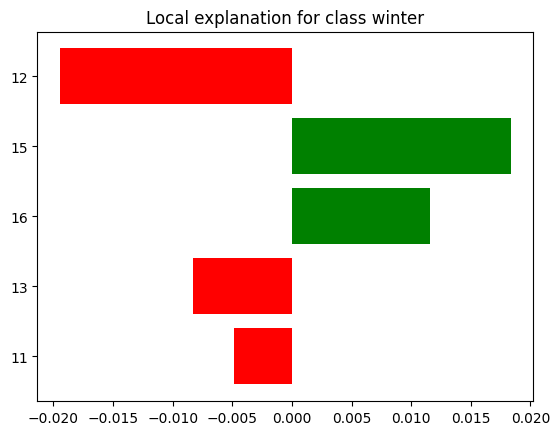

In [43]:
import matplotlib.pyplot as plt
exp.as_pyplot_figure()

TODO: replace the image with dianna visualization module.

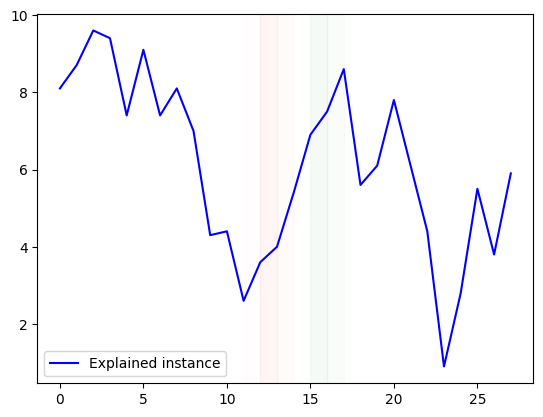

In [46]:
import math

values_per_slice = math.ceil(len(data_instance[0]) / num_slices)
plt.plot(data_instance[0], color='b', label='Explained instance')
plt.legend(loc='lower left')

for i in range(num_features):
    feature, weight = exp.as_list()[i]
    start = feature * values_per_slice
    end = start + values_per_slice
    color = 'red' if weight < 0 else 'green' 
    plt.axvspan(start , end, color=color, alpha=abs(weight*2))
plt.show()

#### 5 - Conclusions
TODO: summarize the results and add conclusions to this notebook.